# dS2 guide and example application
This document will give a short guide on how to setup the model, and how to run the model with some example data. This example will give 1 month of forcing data from the ERA5 reanalysis product for the Rhine basin. 

## Required input data
### Forcing data
- `forc_precipitation.dat`
- `forc_evaporation.dat`
- `forc_temperature.dat`

The .dat files are Numpy memmap files, meaning that no metadata is stored within these files. See [this link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.memmap.html) for more information and examples on how to use this dataformat. Essentially, these files contain 2D arrays with the following shape (*number_of_timesteps*, *number_of_pixels*). As these files do not contain metadata, it is important to enter the correct start and end timestamp of the forcing data in the model settings file (data_start and data_end). 

Note: radiation data is currently not included, in order to keep the example as clean as possible. Radiation data can easily be added when transformed into the same format as the other input data. 

### Static maps
- `map_catchment.asc`
- `map_distance.asc`
- `routing_info.pkl`

Catchment map is a 2D array indicating the location of the (sub-)catchments, with 'nan' indicating pixels outside the catchment. The number of pixels with a value should be equal to the *number_of_pixels* mentioned above.

The distance map indicates the distance from each pixel to the main catchment outlet. This can be created using `pcraster` for example. 

The pickle object `routing_info.pkl` contains three objects at the following order: 
1. `outletIndices`: a Python dictionary with the outlet IDs as keys, and the row/column index of the location of the outlet as value, according to the `catchment.asc`.
2. `allIndices`: a Python dictionary with the outlet IDs as keys, and all row/column indices where that (sub-)catchment is located as value. 
3. `outletINFO`: a Python dictionary with the outlet IDs as keys, and a list with two items as value: the first item shows the ID of the downstream basin, and the distance from the outlet to the downstream outlet (["nan", 0] for the main outlet).

An example script is given in the `input` directory on how one can calculate these values.

### Parameter maps
(Optional, can be defined in the model settings file)
- `par_alpha.asc`
- `par_beta.asc`
- `par_gamma.asc`

Parameter maps can be defined with the same shape and extend as the `map_catchment.asc` map. The value in each pixel represents the parameter value of that pixel. Parameter maps can currently be entered for the $\alpha$, $\beta$, $\gamma$, $\epsilon$ parameters. Uniform parameter values can be entered in the settings file.

### Initial conditions
(Optional, can be defined in the model settings file)
- `init_Qsim.asc`
- `init_Sstore.asc`

Initial maps can be entered for discharge and snow storage. Uniform initial conditions can be entered in the settings file. 


## Running the model


### Preparing the Python environment
First we need to load the required libraries. The model code is located in the parent directory of this one, and we import the model settings from the Python file in this example directory.

In [1]:
# Add the folder above to the Python path
import sys 
sys.path.append("..")

# Import the model code and model settings
from dS2_model import dS2
from dS2_settings import ModelSettings

Now that we have loaded all the required libraries, we can create a model and run it. This can be done with the following commands.

In [2]:
# Load the model settings
Settings = ModelSettings()

# Create the model 
mod = dS2()

# Load the settings into the model
mod.model_setup_class(Settings)
# Generate the runoff for every pixel
mod.generate_runoff() # add this argument for a progressbar: progress=True
# Rout the generated runoff trough the river network
mod.routing()

>>> Preparing input...
>>> Generating discharge...
>>> Routing...


When the model is done running, the results can easily be plotted with Python plotting libraries, such as matplotlib.

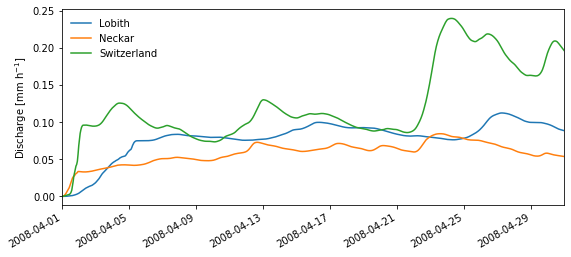

In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

xdate = mod.sim_period.to_pydatetime()

fig=plt.figure(figsize=(9, 4))
ax = fig.subplots(1)
ax.plot(xdate, mod.Qrout["1.0"], label="Lobith")
ax.plot(xdate, mod.Qrout["11.0"], label="Neckar")
ax.plot(xdate, mod.Qrout["13.0"], label="Switzerland")
ax.set_xlim([xdate[0], xdate[-1]])
ax.set_ylabel("Discharge [mm h$^{-1}$]")
ax.legend(frameon=False)
fig.autofmt_xdate()